# IAPR project - Part 3

In [1]:
import numpy as np
import skimage.io
import os
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.morphology import closing, opening, square, disk
from skimage.color import label2rgb

In [2]:
# For deep learning
import torch

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
from torch import optim
from sklearn.metrics import confusion_matrix

In [9]:
import tarfile
import os
data_folder = 'data'
data_filename = 'project-data'
tar_path = os.path.join(data_folder, data_filename + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_folder)

In [10]:
data_folder = 'data'
data_filename = 'project-data'

In [11]:
train_path = os.path.join(data_folder, data_filename, 'images', 'train')
train_annotations_path = os.path.join(data_folder, data_filename, 'annotations', 'train')

test_path = os.path.join(data_folder, data_filename, 'images', 'test')
test_annotations_path = os.path.join(data_folder, data_filename, 'annotations', 'test')

## Useful functions

In [12]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [13]:
# function to compute the intersection, union and iou

def area(box):
    return box[2]*box[3]

def overlap_area(box1, box2):
    '''
    reminder box structure: [x_center, y_center, w, h]
    convention: x = ↓ (height) and y = → (width)
    hence: 
        - w = maxc-minc = y_max-y_min
        - h = maxr-minr = x_max-x_min
    '''
    x_center_1 = box1[0]
    y_center_1 = box1[1]
    w1 = box1[2]
    h1 = box1[3]
    x_min_1 = x_center_1-(h1/2)
    x_max_1 = x_center_1+(h1/2)
    y_min_1 = y_center_1-(w1/2)
    y_max_1 = y_center_1+(w1/2)
    
    x_center_2 = box2[0]
    y_center_2 = box2[1]
    w2 = box2[2]
    h2 = box2[3]
    x_min_2 = x_center_2-(h2/2)
    x_max_2 = x_center_2+(h2/2)
    y_min_2 = y_center_2-(w2/2)
    y_max_2 = y_center_2+(w2/2)
    
    dx = min(x_max_1, x_max_2) - max(x_min_1, x_min_2)
    dy = min(y_max_1, y_max_2) - max(y_min_1, y_min_2)
    
    if (dx >= 0) and (dy >= 0):
        return dx*dy
    else: 
        return 0
    
def union_area(box1, box2):
    return (area(box1) + area(box2) - overlap_area(box1, box2))
    
def IoU(box1, box2):
    return (overlap_area(box1, box2) / overlap_area(box1, box2))

In [14]:
def compute_statistics(varroa_ground_truth, varroa_pred, threshold=0.3):
    ious = []
    tp = 0
    fn = 0
    fp = 0
    for i in varroa_ground_truth:
        iou_tmp = 0
        for j in varroa_pred:
            if (overlap_area(i, j) != 0):
                if IoU(i, j) > iou_tmp:
                    iou_tmp = IoU(i, j)

        if iou_tmp > threshold:
            tp +=1
        else:
            fn += 1

    for i in varroa_pred:
        iou_tmp = 0
        for j in varroa_ground_truth:
            if (overlap_area(i, j) != 0):
                if IoU(i,j) > iou_tmp:
                    iou_tmp = IoU(i, j)

        if iou_tmp < threshold:
            fp +=1
    if ((tp + fp) != 0):
        precision = tp / (tp + fp)
    else:
        precision = 0
    if (tp + fn) != 0:
        recall = tp / (tp + fn)
    else:
        recall = 0
    if (precision + recall) != 0: 
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0
    
    return precision, recall, f1

In [15]:
def sliding_window(img, window_size, step):
    '''
    Take an image as input and return a list of smaller images which correspond to sequences of the original image.
    The original image is scanned from top to bottom and left to right
    
    We will still follow Python indexing, such that:
        x = ↓ (height) 
        y = → (width)
    
    window_size: tuple [height, width]
    
    Input: original image (grayscale for the moment)
    Output: list of sub-images together with the location of that window [x_min, x_max, y_min, y_max]
            
                 y_min      y_max
                  |          |
          x_min _  __________
                  |          |
                  |          |
                  |          |
          x_max _ |__________|
          
            
    '''
    sub_imgs = []
    sub_imgs_location = []
    for x in range(0, img.shape[0], step):
        for y in range(0, img.shape[1], step):
            sub_img = img[x:x+window_size[0], y:y+window_size[1]]
            # Neglect for the moment border to have img of equal size
            if (sub_img.shape[0] == window_size[0]) and (sub_img.shape[1] == window_size[1]):
                sub_imgs.append(sub_img)
                
                x_min = x
                x_max = x + window_size[0] #img.shape[0]
                y_min = y
                y_max = y + window_size[1] #img.shape[1]
                
                sub_imgs_location.append([x_min, x_max, y_min, y_max])
    
    return sub_imgs, sub_imgs_location

In [16]:
def get_centers(xlm_file):
    '''
    Reminder: the annotation box follows the notation: [minc, minr, w, h] 
    
    Still following the Python indexing convention:
        x = ↓ (height) 
        y = → (width)
   
    It is translated into: [y_min, x_min, w, h]
    
    INPUT
    The function take as input the name of the xlm file
    
    OUTPUT
    The function returns a list of centers: [[x_center_1, y_center_1], ..., [x_center_N, y_center_N]]
    '''
    annotations_xml = parse_file(xlm_file)
    
    centers = []
    for anno in annotations_xml:
        box = anno['bbox']
        y_min = box[0]
        x_min = box[1]
        w = box[2]
        h = box[3]

        x_center = (x_min+h/2) 
        y_center = (y_min+w/2)
        
        centers.append([x_center, y_center])
    
    return centers  
    

In [17]:
def get_centers_and_boxes(xml_file):
    '''   
    Boxes format in xmls: [minc, minr, w, h]
    
    Using x ↓ and y = → : [y_min, x_min, w, h]
    
    Input: path to xml file
    Output: 
        - centers [x, y] = [row, col]
        - boxes [minc, minr, w, h]
        
    Note: box boundaries can easily be retrieved
        - x_max = x_min + h
        - y_max = y_min + w
    '''
    annotations_xml = parse_file(xml_file)
    
    centers = []
    boxes = []
    for anno in annotations_xml:
        box = anno['bbox']
        y_min = box[0]
        x_min = box[1]
        w = box[2]
        h = box[3]

        x_center = (x_min+h/2) 
        y_center = (y_min+w/2)
        
        centers.append([x_center, y_center])
        boxes.append(box)
    
    return centers, boxes

## Let's get started

**Approach**

**Build classifier = CNN**

The aim of this part is to detect the presence of varroa with the help of a CNN.

If and only if the sub-window contains the entire varroa, attribute a label of 1 to this sub-image.
- Take the image of the test one after another
- For each image get useful infos from the annotations
- For each image, use the *sliding window* method to obtain sub-images
- For each sub-image check whether a center is included in that image.
    - If yes: check if the whole boxe is contained in that subimage
        - If yes: give a label 1 + add information about the bounding box!
        - If no: give a label 0
    - If no: give a label 0

Indeed, the key here is to define the target label $y$. Our network should output:
- the class of the object: [1, 0] (equal to asses the presence only as we have 2 classes)
- the bounding box information = 4 parameters that allow to fully characterize the box

Hence, the label vector $y$ could be of the form: [1, 0, minc, minr, w, h]

Note: all these subimages constitute our set to train the model with the corresponding labels.


**Training** aining is achieved using the loss. In practice, we will use:
- CrossEntropyLoss for the classification (binary classification)
- MSELoss for the bounding box informations

The backward is finally computed on the combination of these 2 losses.

(2nd strategy: onyl check whether the center is included in the sub-window = sufficient condition to add label 1
No, do not proceed like that!)

In [18]:
'''
labels: contain class only
        - 1 if a varroa is present
        - 0 if no varroa (no object)

targets: contains all information such that
        - object present: [1, 0, minc, minr, w, h]
        - object not present: [0, 1, 0, 0, 0, 0]

dataset: contain all sub-images across all the test directory
         1 sub-image = 1 train sample
         (hence equal window size across the images, 
         it hence assumes that varroas have the same 'size'
         in all images. The validity of this assumption can
         be discussed. Can be solved by scaling images)
         
/!\ assumption: the sub-image contains only one object
'''

# Get names of all images in the test repo without extension
list_dir = os.listdir(train_annotations_path) #or test_path #TRAINTEST
names = []

for name in list_dir:
    n = os.path.splitext(name)[0]
    names.append(n)

    
dataset = []
labels = []
targets = []
for name in names:
    img = skimage.io.imread(os.path.join(train_path, name + '.jpg')) #TRAINTEST
    img_gs = skimage.color.rgb2gray(img)
    
    #xml_file_name = test_annotations_path + '/' + name + '.xml'
    
    centers, boxes = get_centers_and_boxes(train_annotations_path + '/' + name + '.xml') #TRAINTEST
    
    sub_windows, sub_windows_location = sliding_window(img_gs, [70, 70], 40) #80-20
    
    #labels = []
    #targets = []
    
    for im, loc in zip(sub_windows, sub_windows_location):
        # windows properties
        x_min = loc[0]
        x_max = loc[1]
        y_min = loc[2]
        y_max = loc[3]

        tmp = []
        for centre, box in zip(centers, boxes):
            x_center = centre[0]
            y_center = centre[1]

            # true boxes properties
            minc = box[0] #ymin of the box
            minr = box[1] #xmin
            w = box[2] 
            h = box[3]
            maxc = minc+w #ymax
            maxr = minr+h #xmax

            # Check center belong to the sub-image
            if (x_center < x_max) and (x_center > x_min) and (y_center < y_max) and (y_center > y_min):
                # Now check that the entire box belong to the sub image
                if (minr > x_min) and (maxr < x_max) and (minc > y_min) and (maxc < y_max):
                    tmp.append(1)
                else:
                    tmp.append(0)
            else:
                tmp.append(0)
        # Assess the presence of a whole object
        if np.sum(tmp) > 0:
            labels.append(1)
            targets.append([1, 0, minc, minr, w, h])
        else:
            labels.append(0)
            targets.append([0, 1, 0, 0, 0, 0]) #TODO: not sur it's a good idea to define the absence of bounding box by 0s
        
        # Store the image
        dataset.append(im)
        
    #test_labels.append(labels)
    #test_targets.append(targets) #je crois ici qu'on aura un probleme (des list de list de blablabla)

In [ ]:
print(np.array(dataset).shape)
#print(np.array(labels).shape)

In [ ]:
#ok that's huge

## CNN

#### Useful functions
- Training
- Convert labels to One-hot-encoding format
- Compute the number of errors
- Split the data in a train and test set
- ...

In [19]:
def one_hot(labels, nb_labels):
    '''
    input labels can be either np array or tensors
    output is a torch.Tensor
    '''
    if (type(labels) == np.ndarray):
        h_labels = (np.arange(nb_labels) == labels[:, None]).astype(np.float32)

    elif (type(labels) == torch.Tensor):
        h_labels = labels.numpy()
        h_labels = (np.arange(nb_labels) == h_labels[:, None]).astype(np.float32)
        
    else:
        raise ValueError('The input type must be either numpy.ndarray or torch.Tensor')
    
    return torch.Tensor(h_labels) 

In [20]:
def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [21]:
def train_model(model, train_input, train_target, crit, mini_batch_size, monitor_params):
    '''
    crit: criterion. MSELoss() or CrossEntropyLoss().
    Cross entropy usually preferred for classification tasks.
    train_target: labels equired to compute the error.
    '''
    criterion = crit
    #criterion = nn.MSELoss()
    #criterion = nn.BCELoss()
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    nb_epochs = 10
    
    loss_storage = []
    error_storage = []
    accuracy_storage = []
    
    
    for e in range(nb_epochs):
        sum_loss = 0
        sum_error = 0
        sum_acc = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            
            output = model(train_input.narrow(0, b, mini_batch_size))
            
            ### Compute class from the output ###
            _, predicted_classes = torch.max(output.data, 1)
            
            ### Compute loss ###
            #loss = criterion(output, h_train_target.narrow(0, b, mini_batch_size)) # if using MSE
            loss = criterion(output, train_target.view(train_target.size(0)).narrow(0, b, mini_batch_size))
            
            ### Compute train error ###
            nb_errors = 0
            for k in range(mini_batch_size):
                if train_target.data[b + k] != predicted_classes[k]:
                    nb_errors = nb_errors + 1
            
            sum_loss += loss.item() # compute loss for each mini batch for 1 epoch
            sum_error += nb_errors
            #sum_acc += acc # ok
            
            model.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Accuracy computed from the number of errors
        sum_acc = (train_input.size(0) - sum_error) / train_input.size(0)
        
        loss_storage.append(sum_loss)
        error_storage.append(sum_error)
        accuracy_storage.append(sum_acc)
                
        print('[epoch {:d}] loss: {:0.2f} error: {} accuracy: {:0.4f}'.format(e+1, sum_loss, sum_error, sum_acc))
        
    
    if monitor_params:
        return loss_storage, error_storage, accuracy_storage

In [22]:
def train_test_split(x, y, ratio, seed=0):
    '''
    Split the data in train, test arrays
    Inputs:
        - x: features vector = 2D array (nb_rows, nb_cols)
        - y: labels
        - ratio: percetange of the data used for testing (between [0, 1[)
    Outputs:
        - x_train, x_test, y_train, y_test
    '''
    np.random.seed(seed)
    nb_samples = x.shape[0]
    idx_split = int(np.floor(ratio * nb_samples))
    
    my_permutation = np.random.permutation(nb_samples)
    x = x[my_permutation, :]
    y = y[my_permutation, :]
    
    x_train, x_test = x[:idx_split, :], x[idx_split:, :]
    y_train, y_test = y[:idx_split, :], y[idx_split:, :]
    
    return x_train, x_test, y_train, y_test

In [23]:
def train_test_split_imgs(x, y, ratio, seed=0):
    '''
    Split the data in train, test arrays
    Inputs:
        - x: features vector = (nb_imgs, nb_rows, nb_cols)
        - y: labels
        - ratio: percetange of the data used for testing (between [0, 1[)
    Outputs:
        - x_train, x_test, y_train, y_test
    '''
    np.random.seed(seed)
    nb_samples = x.shape[0]
    idx_split = int(np.floor(ratio * nb_samples))
    
    my_permutation = np.random.permutation(nb_samples)
    x = x[my_permutation, :, :]
    y = y[my_permutation]
    
    x_train, x_test = x[:idx_split, :, :], x[idx_split:, :, :]
    y_train, y_test = y[:idx_split], y[idx_split:]
    
    return x_train, x_test, y_train, y_test

#### Network

Simple netowrk consisting in:
- 2 convolutional layers
    - kernel_size_1 = 5, 16 output channels
    - kernel_size_2 = 3, 32 output channels
- 2 max_pooling
    - kernel_size_1 = 3
    - kernel_size_2 = 2
- 2 fully-connected layers
- ReLU used as activation function
- Dropout to reduce overfitting (+ ev. BatchNorm)

As suggested previously, the total loss will be a combination of the loss from the classification process and from the box 'process'. 

Key: the **backward** is called once on the entire network!

Input: sub images of size [70, 70]

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)

        self.fc1 = nn.Linear(3200, 500)
        self.fc2 = nn.Linear(500, 2)
        #self.fc3 = nn.Linear(768,2)
        self.dropout = nn.Dropout() 
        self.batchnorm = nn.BatchNorm1d(20)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 3) #TODO: stride
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1, 3200)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

As a first step, we will just test the classification process, i.e. is there a varroa or not.

For the classification, input (i.e. sub-images) as well as labels (i.e. 1 or 0) need to be converted to *Tensors*.
- input shape: torch.Size([nb_samples, 1, h, w])
- label shape: torch.Size([nb_samples, 1])

Note that there are obviously much more 0-class (no object) than varroa in images. Hence both classes are heavily unbalanced. To solve the problem, we can count the number of positive labels and take a reasonnably proportionnal number of the other class.

Furhermore, MCC help to deal with ubalanced classes.

#### Main

In [25]:
# Count the number of class 1
nb_varroas = np.sum(labels)
print(nb_varroas)

7268


In [26]:
features = np.array(dataset)
#print(features.shape)

MemoryError: 

In [16]:
varroas_imgs = features[np.where(labels), :, :]
varroas_imgs = varroas_imgs.reshape(nb_varroas, 70, 70)
varroas_imgs.shape

(490, 70, 70)

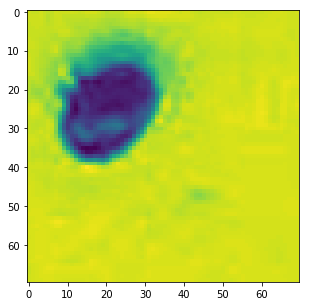

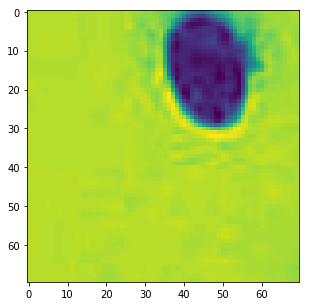

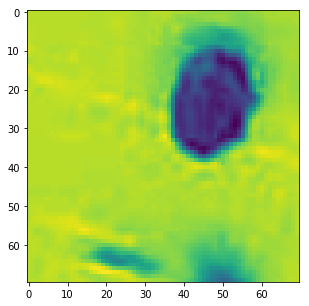

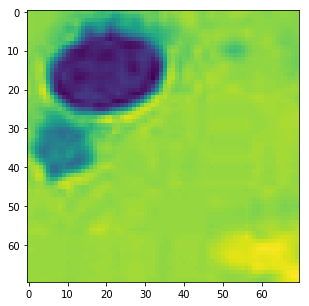

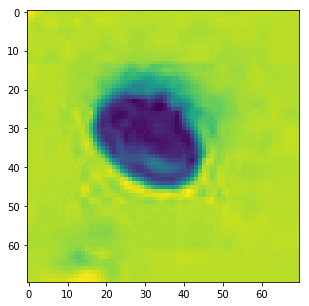

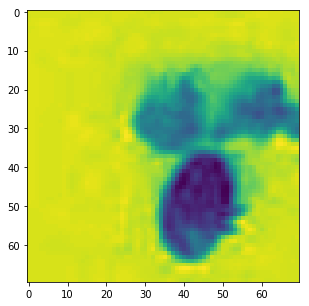

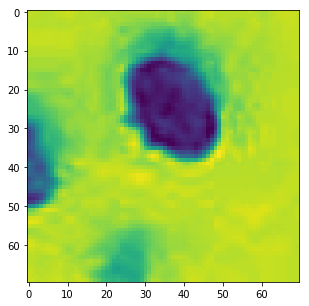

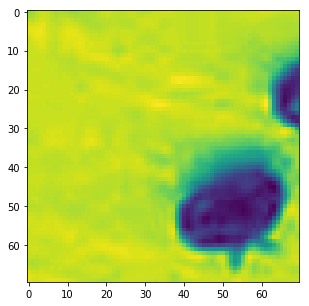

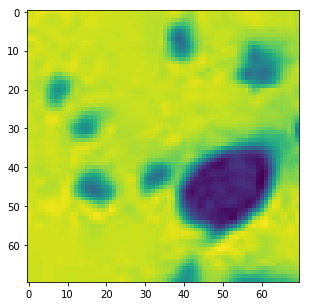

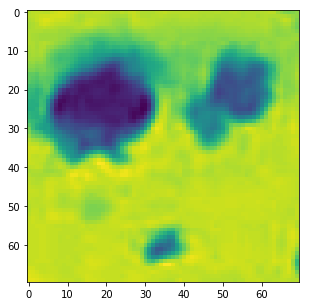

In [75]:
for i in range(10):
    v = varroas_imgs[i, :, :]
    plt.figure(figsize=(5,5))
    plt.imshow(v)

In [17]:
lab = np.array(labels)
print(lab.shape)

(91590,)


In [20]:
background_imgs = features[np.where(lab==0), :, :]
background_imgs = background_imgs.reshape(91100, 70, 70)
print(background_imgs.shape)

(91100, 70, 70)


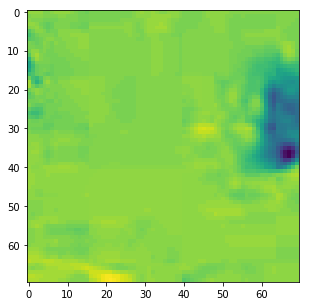

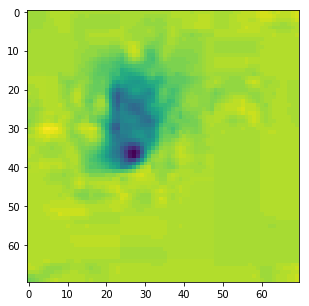

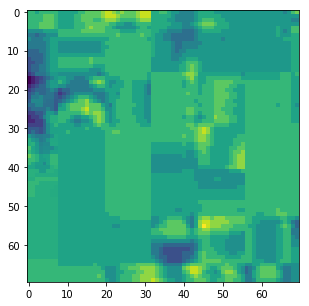

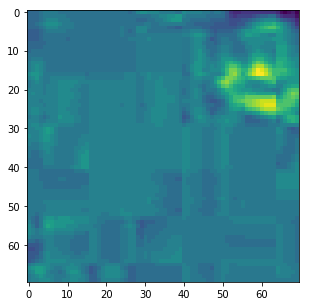

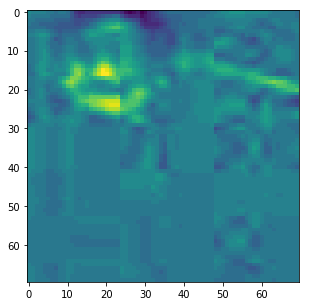

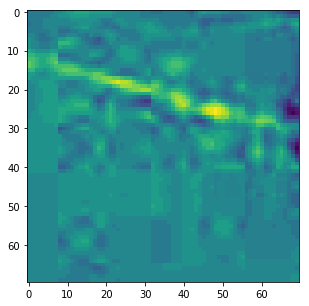

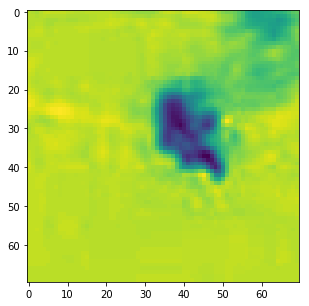

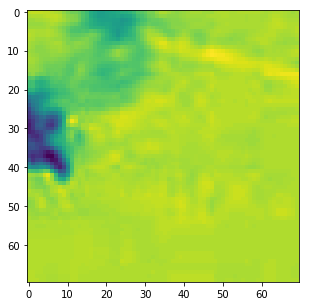

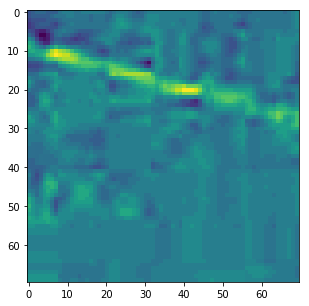

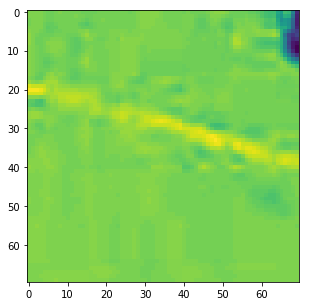

In [24]:
for i in range(10):
    b = background_imgs[i+10, :, :]
    plt.figure(figsize=(5,5))
    plt.imshow(b)

In [44]:
# Select a reasonnable number of background images (let's say 1500)
# Shuffle background array and take the 1500 first images
n = 1500

permutations = np.random.permutation(background_imgs.shape[0])
background_subset = background_imgs[permutations, :, :]
background_subset = background_subset[:n, :, :]
print(background_subset.shape)

MemoryError: 

In [43]:
background_subset.shape

(1500, 70, 70)

In [50]:
features_subset = np.concatenate((background_subset, varroas_imgs), axis=0)
features_subset.shape

(1990, 70, 70)

In [54]:
zero_labels = np.zeros(background_subset.shape[0])
one_labels = np.ones(varroas_imgs.shape[0])
labels_subset = np.concatenate((zero_labels, one_labels), axis=0)
print(labels_subset.shape)

(1990,)


Note: we have our sub-train data in order (i.e. 0 first, then 1) but the *train_test_split_imgs* methos will allow to shuffle this array.

In [23]:
# ev. reshape to enable the use of mini_batch (if not way too long)
#features = features[:91000, : , :]
#print(features.shape)

(91000, 70, 70)


In [24]:
# same for labels
#lab = lab[:91000]
#print(lab.shape)

(91000,)


In [55]:
train_input, test_input, train_target, test_target = train_test_split_imgs(features, labels, 0.80)

#Convert to tensors
train_input = torch.Tensor(train_input)
test_input = torch.Tensor(test_input)
train_target = torch.Tensor(train_target).long()
test_target = torch.Tensor(test_target).long()

train_input = train_input.view(train_input.shape[0], 1, train_input.shape[1], train_input.shape[2])
test_input = test_input.view(test_input.shape[0], 1, test_input.shape[1], test_input.shape[2])

# Sanity check
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

MemoryError: 

In [ ]:
mini_batch_size = 100
model = Net()
crit = nn.CrossEntropyLoss()

losses_, errors_, accuracies_ = train_model(model, train_input, train_target, crit, mini_batch_size, True)

nb_train_errors = compute_nb_errors(model, train_input, train_target)

model.train(False)
nb_test_errors = compute_nb_errors(model, test_input, test_target)

print('Train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                      nb_train_errors, train_input.size(0)))
print('Test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
           
                                           nb_test_errors, test_input.size(0)))


[epoch 1] loss: 25.05 error: 407 accuracy: 0.9944
[epoch 2] loss: 19.33 error: 378 accuracy: 0.9948
[epoch 3] loss: 16.70 error: 378 accuracy: 0.9948
[epoch 4] loss: 15.18 error: 379 accuracy: 0.9948
[epoch 5] loss: 15.10 error: 377 accuracy: 0.9948
[epoch 6] loss: 14.80 error: 380 accuracy: 0.9948
[epoch 7] loss: 14.14 error: 373 accuracy: 0.9949
[epoch 8] loss: 14.29 error: 387 accuracy: 0.9947
[epoch 9] loss: 14.00 error: 369 accuracy: 0.9949
[epoch 10] loss: 13.63 error: 372 accuracy: 0.9949
Train error Net 0.50% 364/72800
Test error Net 0.58% 105/18200


In [1]:
# Confusion matrix
test_output = model(test_input)
_, predicted_test_classes = torch.max(test_output.data, 1)


tn, fp, fn, tp = confusion_matrix(test_target.view(test_target.size(0)).numpy().tolist(), 
                                  predicted_test_classes.numpy().tolist()).ravel()


mcc = (tp*tn - fp*fn) / (np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * (precision * recall) / (precision + recall)

print('MCC: {:0.2f} \nPrecision: {:0.2f} \nRecall: {:0.2f} \nF-score: {:0.2f}'.format(mcc, precision, recall, f_score))
print('tn: {:0.2f} \nfp: {0.2f} \nfn: {0.2f} \ntp: {0.2f}'.format(tn, fp, fn, tp))

NameError: name 'tn' is not defined

In [ ]:
# Seems to have a problem, try to use all labelled varroas with a proportionnal number of 0-class.

In [15]:
np.array(labels).shape

(91590,)

In [16]:
np.sum(labels)

490

In [18]:
np.where(labels)

(array([    1,    27,   113,   120,   208,   430,   442,   881,  1944,
         1970,  2016,  2050,  2092,  2121,  2155,  2200,  2265,  2336,
         2403,  2494,  2585,  2630,  2641,  2674,  2746,  2747,  2751,
         2758,  2795,  2803,  2888,  3036,  3122,  3214,  3230,  3317,
         3417,  3482,  3502,  3567,  3601,  3969,  4018,  4344,  4466,
         4497,  5332,  5717,  6428,  8503,  8504, 12175, 15357, 16671,
        16746, 16800, 16908, 16964, 17327, 17388, 17512, 17643, 18001,
        19721, 20531, 20765, 20915, 20999, 21012, 21246, 21345, 21358,
        21383, 21655, 21656, 21682, 21771, 22001, 22367, 22385, 22448,
        22831, 23105, 23110, 23303, 24136, 24137, 24421, 24983, 25076,
        27521, 27685, 28282, 28483, 33077, 33090, 33205, 33206, 33219,
        33246, 33340, 33341, 33373, 33374, 33425, 33426, 33458, 33459,
        33470, 33757, 33790, 34097, 34130, 38069, 38378, 38444, 38730,
        38774, 38815, 38897, 38902, 38994, 39034, 39068, 39185, 39300,
      